# Read in raw politifact stories, filter for relevant stories

Filter links:
 - twitter or blog
 - between 2021-06-01 and 2023-12-20 
 - truth value in ['pants-fire', 'false', 'mostly-false']
 - health cat in CATEGORIES = ['abortion', 'autism', 'coronavirus', 'drugs', 'disability', 'health-care', 'health-check', 'public-health']

In [1]:
import ast
import pandas as pd 
import numpy as np 
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

START_DATE = '2021-06-01'
END_DATE = '2023-12-21'

CATEGORIES = ['abortion', 'autism', 'coronavirus', 'drugs', 'disability', 'health-care', 'health-check', 'public-health']
TRUTH_VALUES = ['pants-fire', 'false', 'mostly-false']


def is_twitter(desc):
    try:
        desc = desc.lower()
        if "twitter" in desc or "tweet" in desc or "post on x" in desc or "x-post" in desc or "x post" in desc or "en x" in desc:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        return np.NaN
    

def is_blog(desc):
    try:
        desc = desc.lower()
        if "in a blog" in desc or "bloggers" in desc:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        return np.NaN
    
def is_valid_category(x, categories):
    x = [i.lower() for i in x]
    if len(set(x).intersection(set(categories))) > 0:
        return True
    else:
        return False
    
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except:
        return s  
    
input_fn = "raw_pf_links_2023-12-22__10_31_08.csv"
output_fn = "filtered_tweets.csv"


df = pd.read_csv(input_fn)

# Filtered df
df['tags'] = df['tags'].apply(lambda x: safe_literal_eval(x))
df['is_twitter'] = df['raw_desc'].apply(lambda x: is_twitter(x))
df['is_blog_desc'] = df['raw_desc'].apply(lambda x: is_blog(x))
df['is_blog_cat'] = df['type'].apply(lambda x: 1 if x=="Bloggers" else 0)
df['is_blog'] = np.maximum(df['is_blog_desc'], df['is_blog_cat'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
filtered_df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
filtered_df = filtered_df[filtered_df['tags'].apply(lambda x: is_valid_category(x, CATEGORIES))]
filtered_df = filtered_df.query("truth_value in @TRUTH_VALUES")
filtered_df = filtered_df.query("is_twitter==1|is_blog==1")
filtered_df.to_csv(f"raw_{output_fn}")

# One df for manual validation 
filtered_df['annotated_column'] = ''
filtered_df['raw_url'] = ''
filtered_df['twitter_handle'] = ''
filtered_df['n_followers'] = ''
filtered_df.to_csv(f"to_annotate_{output_fn}")

# Now manually annotate and rename "annotated_{output_fn}" so don't write over

# Read in annotated df

In [2]:
adf = pd.read_csv("annotated_filtered_tweets.csv")
adf['date'] = pd.to_datetime(adf['date'], format='%m/%d/%y', errors='coerce')
adf['elected_rep'] = adf['annotated_column'].apply(lambda x: 1 if "elected_rep" in str(x) else 0)
hardcoded_current_date = pd.to_datetime('2023-12-22')
adf['days_since_tweet'] = (hardcoded_current_date - adf['date']).dt.days

print("BEFORE FILTERING")
print("Number of stories", len(adf))
print("Number of spreaders", adf['twitter_handle'].nunique())
print("Number of politicans or elected reps", adf['elected_rep'].sum())


# Filter for things like account suspended
print("FILTERING FOR AVAILABLE HANDLES AND NO REPS")
adf = adf.query("problem==0")
adf = adf[adf['twitter_handle'].notna()]
adf = adf.query("elected_rep==0")
print("Number of stories", len(adf))
print("Number of spreaders", adf['twitter_handle'].nunique())


# Group data 
new_df = adf.groupby('twitter_handle').agg(
    n_followers=('n_followers', 'max'), 
    count=('twitter_handle', 'count'), 
    last_story = ("date", "max"),
    days_ago = ("days_since_tweet", "min")
).reset_index()

new_df['months_ago'] = new_df['days_ago']/30
new_df['log_followers'] = np.log(new_df['n_followers'])

BEFORE FILTERING
Number of stories 89
Number of spreaders 49
Number of politicans or elected reps 9
FILTERING FOR AVAILABLE HANDLES AND NO REPS
Number of stories 52
Number of spreaders 38


# Create some indexes

In [8]:
for var in ['log_followers', 'last_story', 'count']:
    new_df[f'rank_{var}'] = new_df[var].rank(ascending=True)

new_df['rank_neutral_emph'] = (new_df['rank_log_followers'] + new_df['rank_last_story'] + new_df['rank_count'])/3
new_df['rank_count_emph'] = 0.15*new_df['rank_log_followers'] + 0.15*new_df['rank_last_story'] + 0.7*new_df['rank_count']
new_df['rank_follower_emph'] = 0.7*new_df['rank_log_followers'] + 0.15*new_df['rank_last_story'] + 0.15*new_df['rank_count']
new_df['rank_recent_emph'] = 0.15*new_df['rank_log_followers'] + 0.7*new_df['rank_last_story'] + 0.15*new_df['rank_count']
new_df['rank_recent_follow'] = 0.5*new_df['rank_log_followers'] + 0.5*new_df['rank_count']


new_df[[x for x in new_df.columns if "rank_" in x]].corr()

,rank_log_followers,rank_last_story,rank_count,rank_neutral_emph,rank_count_emph,rank_follower_emph,rank_recent_emph,rank_recent_follow
rank_log_followers,1.000000,-0.114364,0.166559,0.603955,0.382979,0.962755,0.117339,0.870494
rank_last_story,-0.114364,1.000000,0.244269,0.633860,0.446805,0.128355,0.965496,0.031882
rank_count,0.166559,0.244269,1.000000,0.636552,0.936117,0.342171,0.398034,0.630292
rank_neutral_emph,0.603955,0.633860,0.636552,1.000000,0.867121,0.796956,0.813409,0.793263
rank_count_emph,0.382979,0.446805,0.936117,0.867121,1.000000,0.584407,0.627989,0.768805
rank_follower_emph,0.962755,0.128355,0.342171,0.796956,0.584407,1.000000,0.364865,0.928826
rank_recent_emph,0.117339,0.965496,0.398034,0.813409,0.627989,0.364865,1.000000,0.291067
rank_recent_follow,0.870494,0.031882,0.630292,0.793263,0.768805,0.928826,0.291067,1.000000


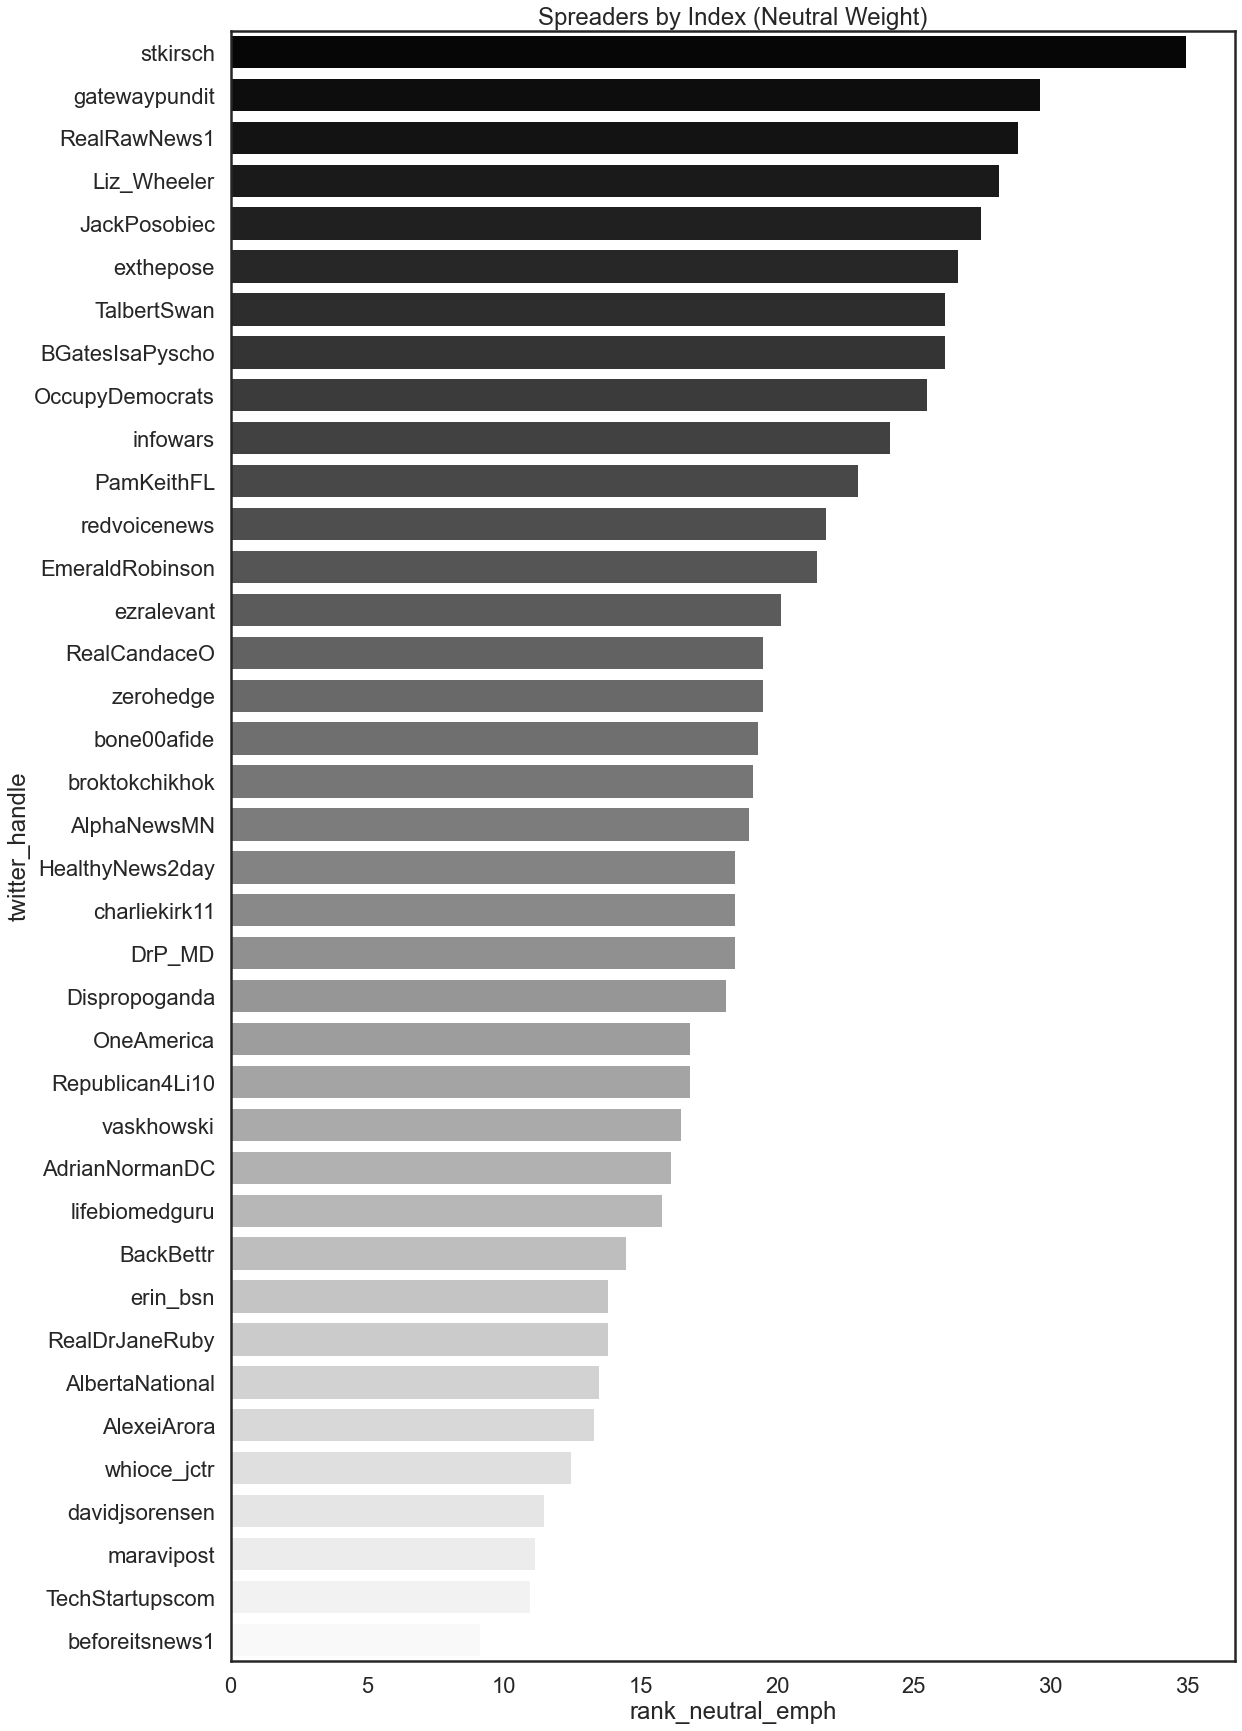

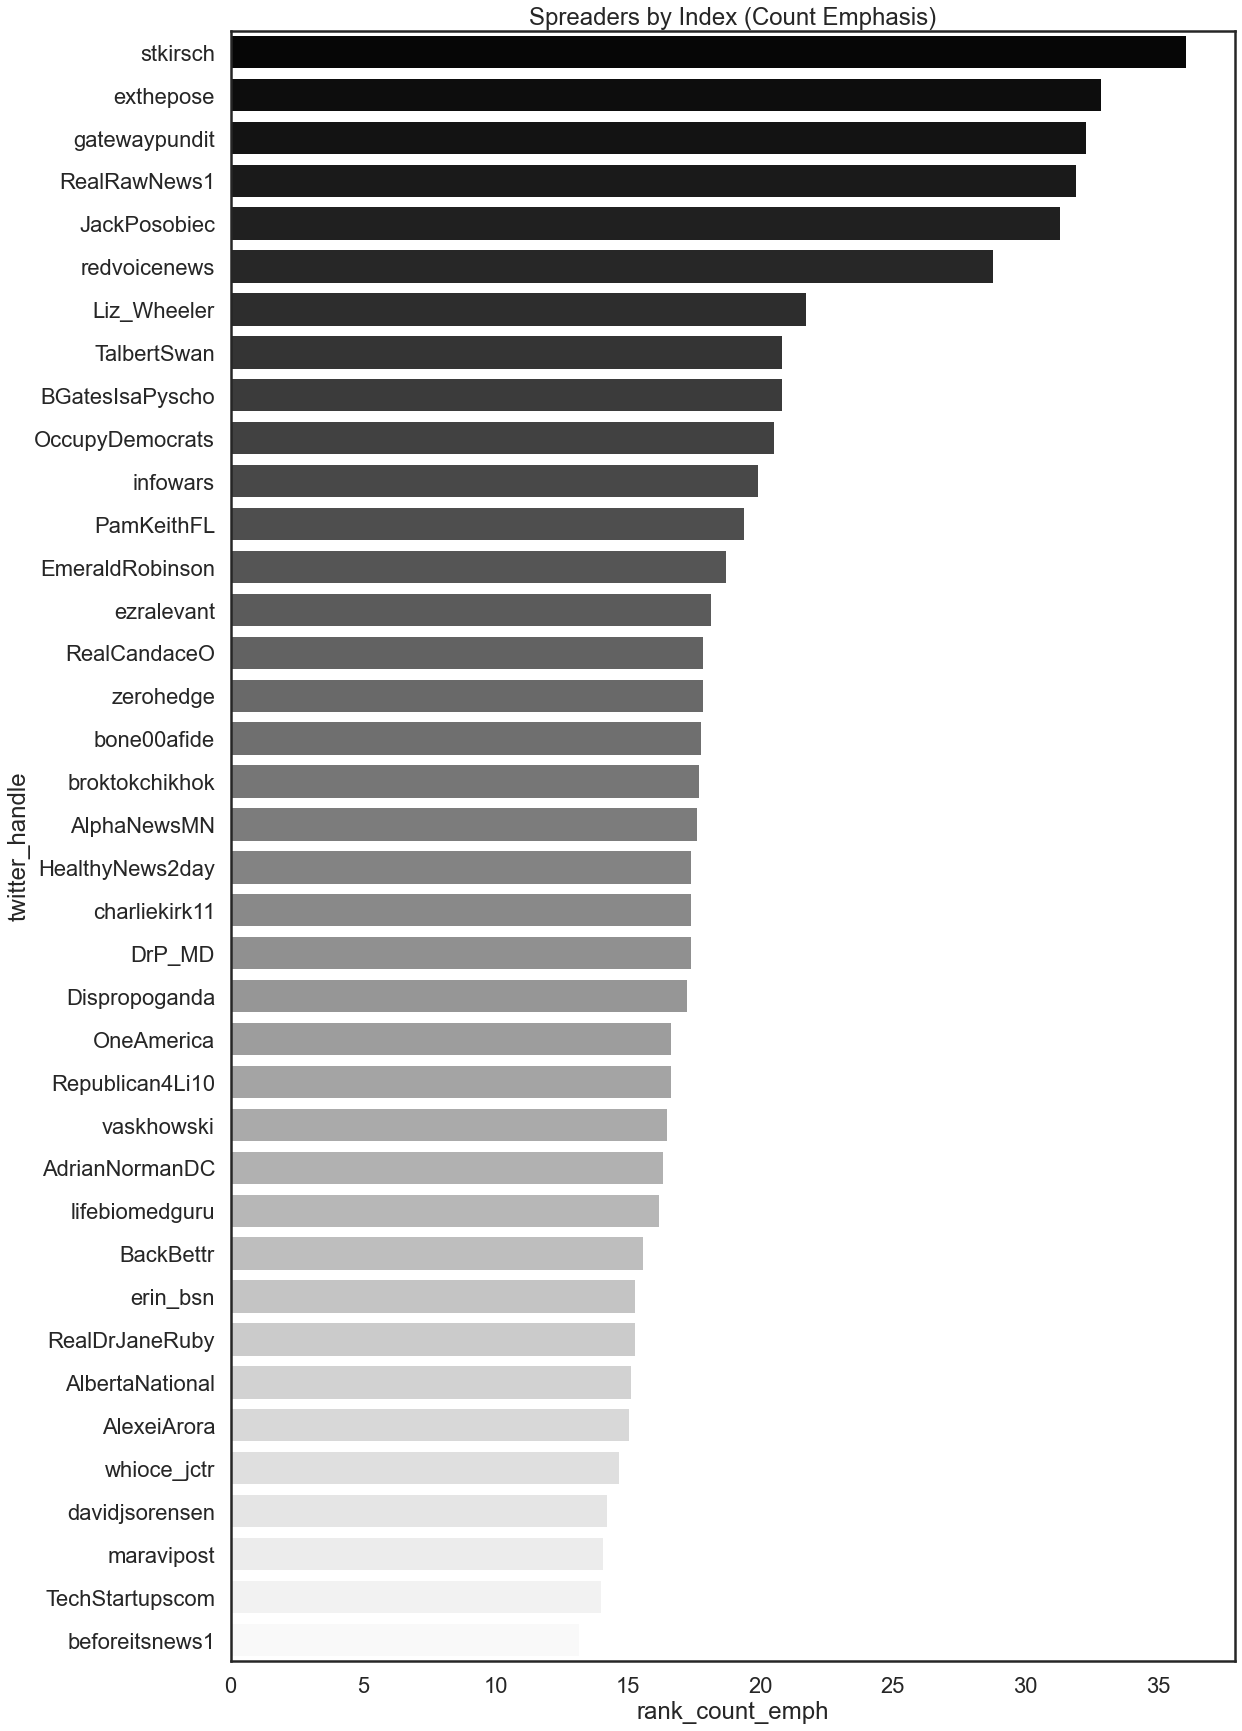

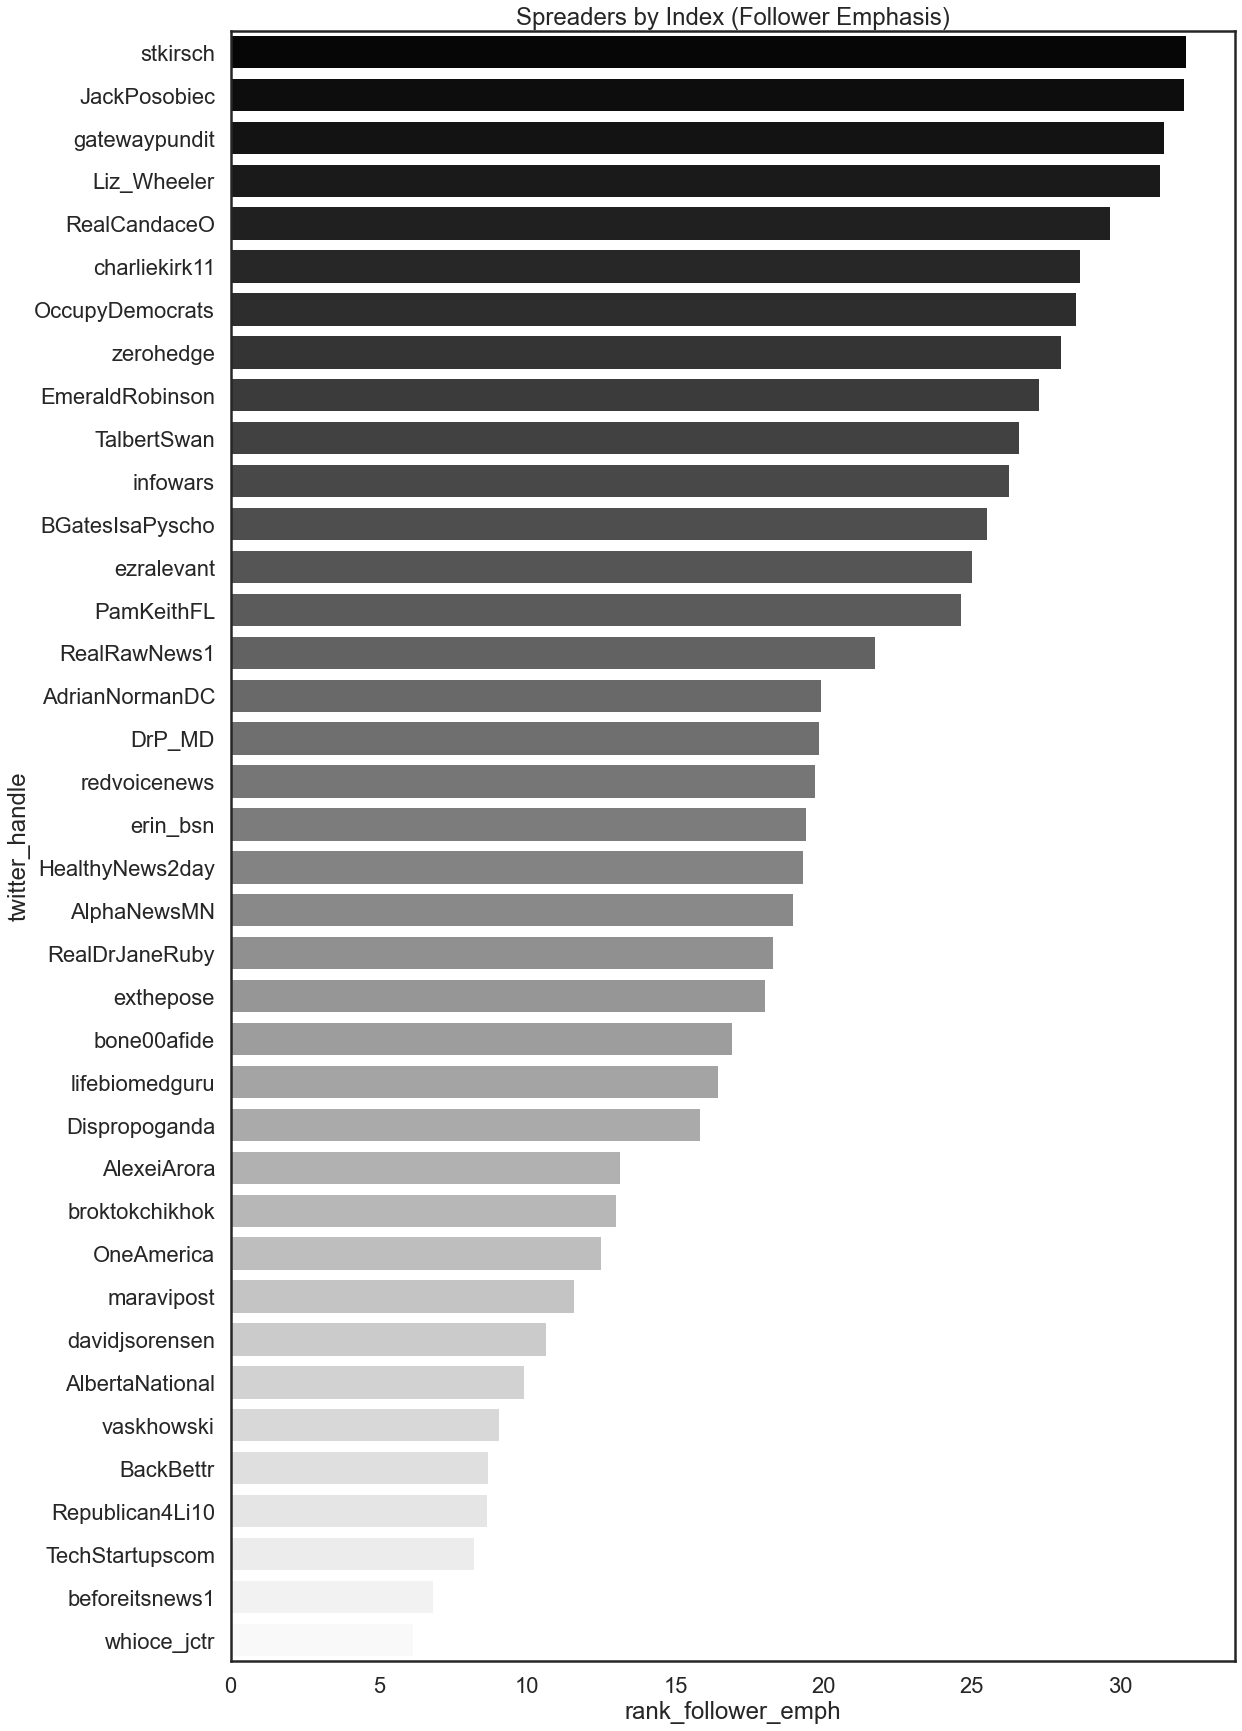

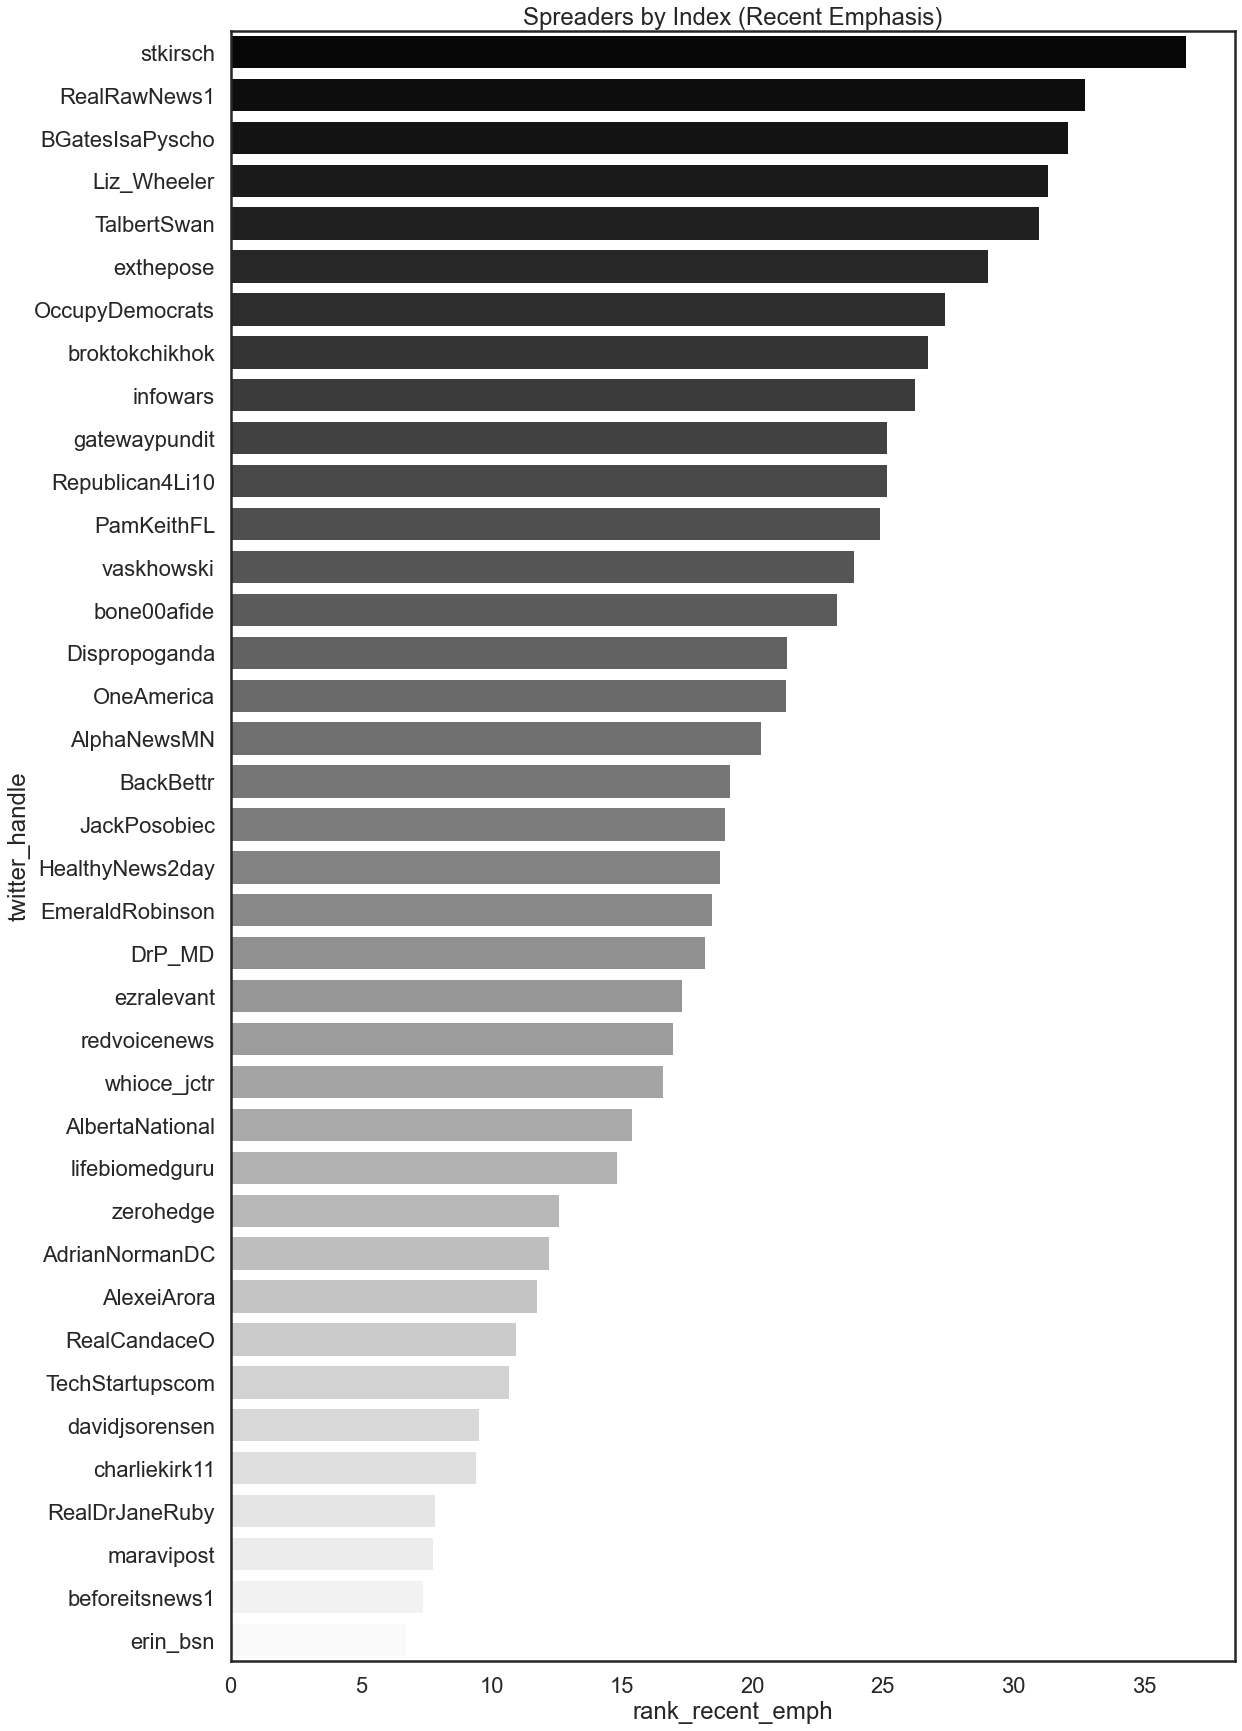

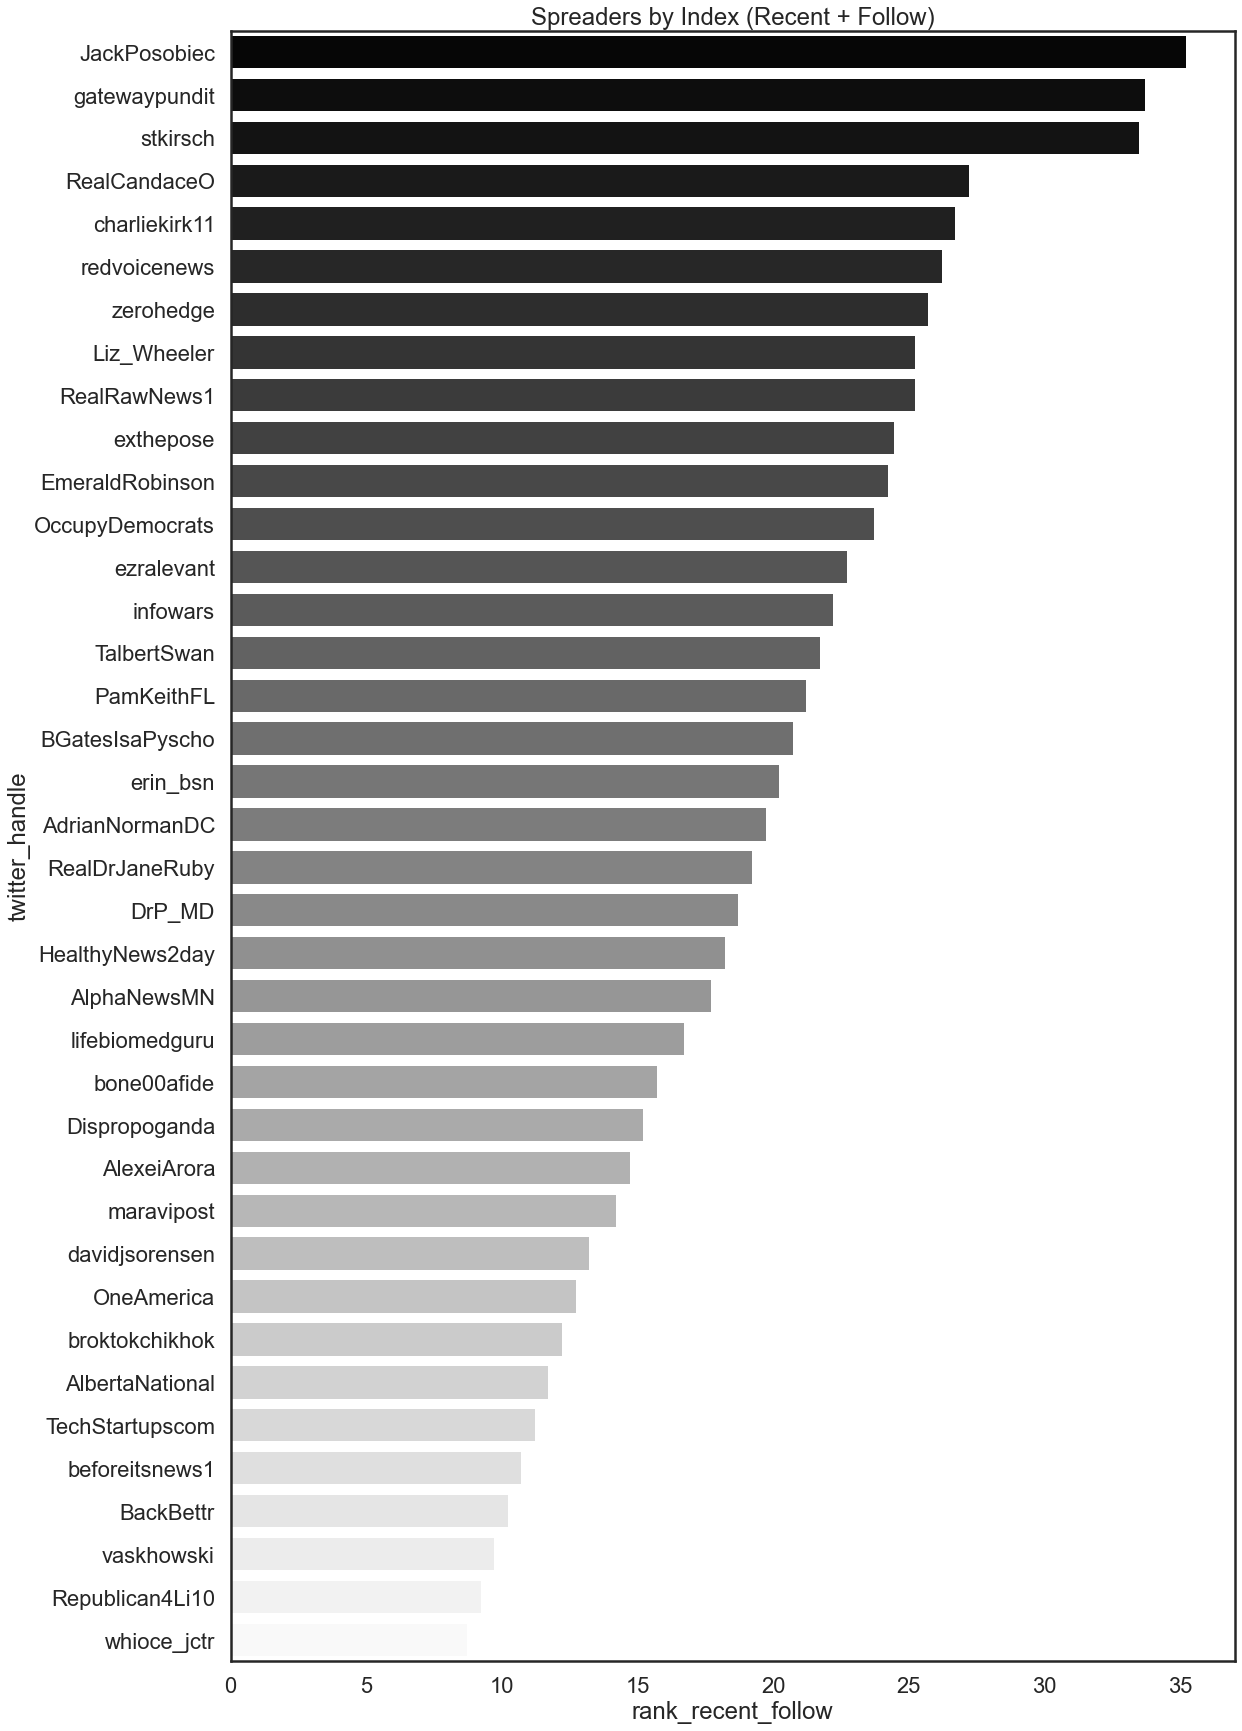

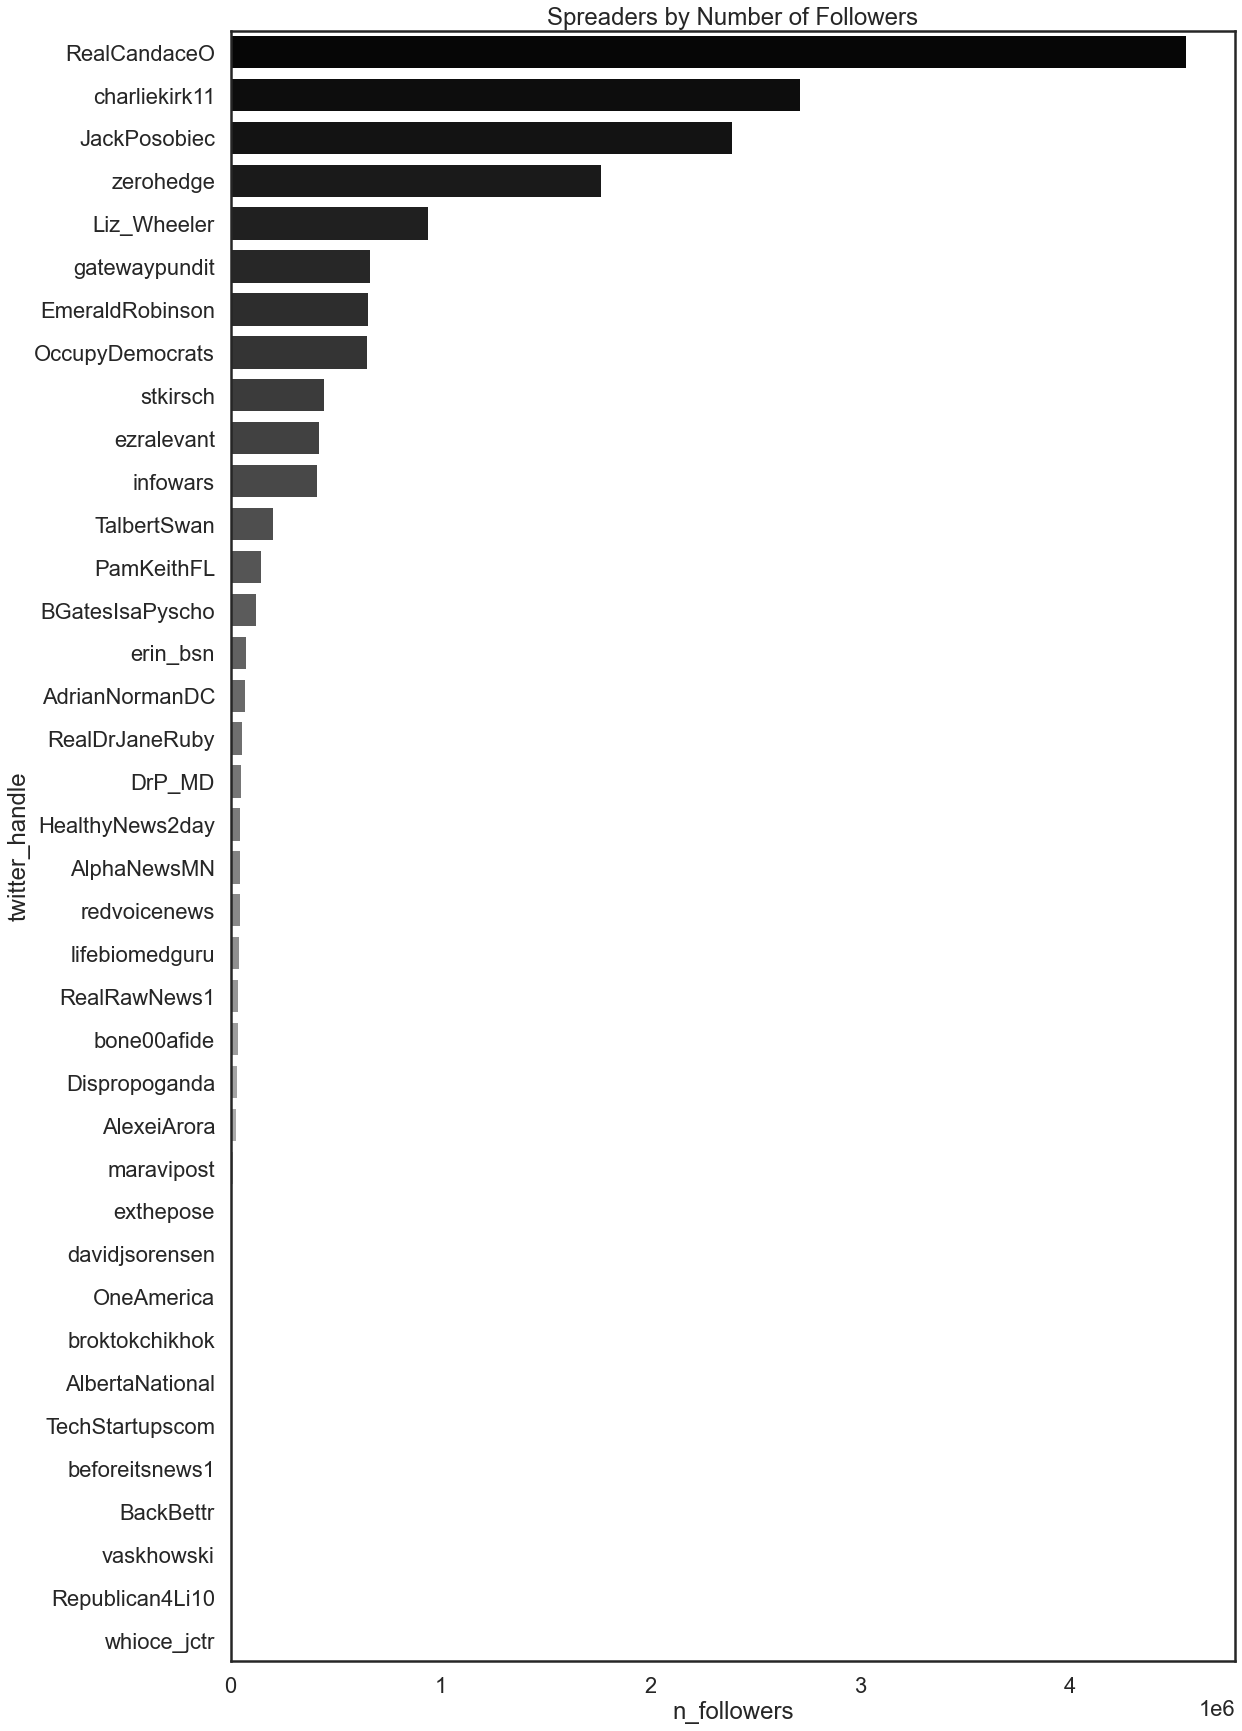

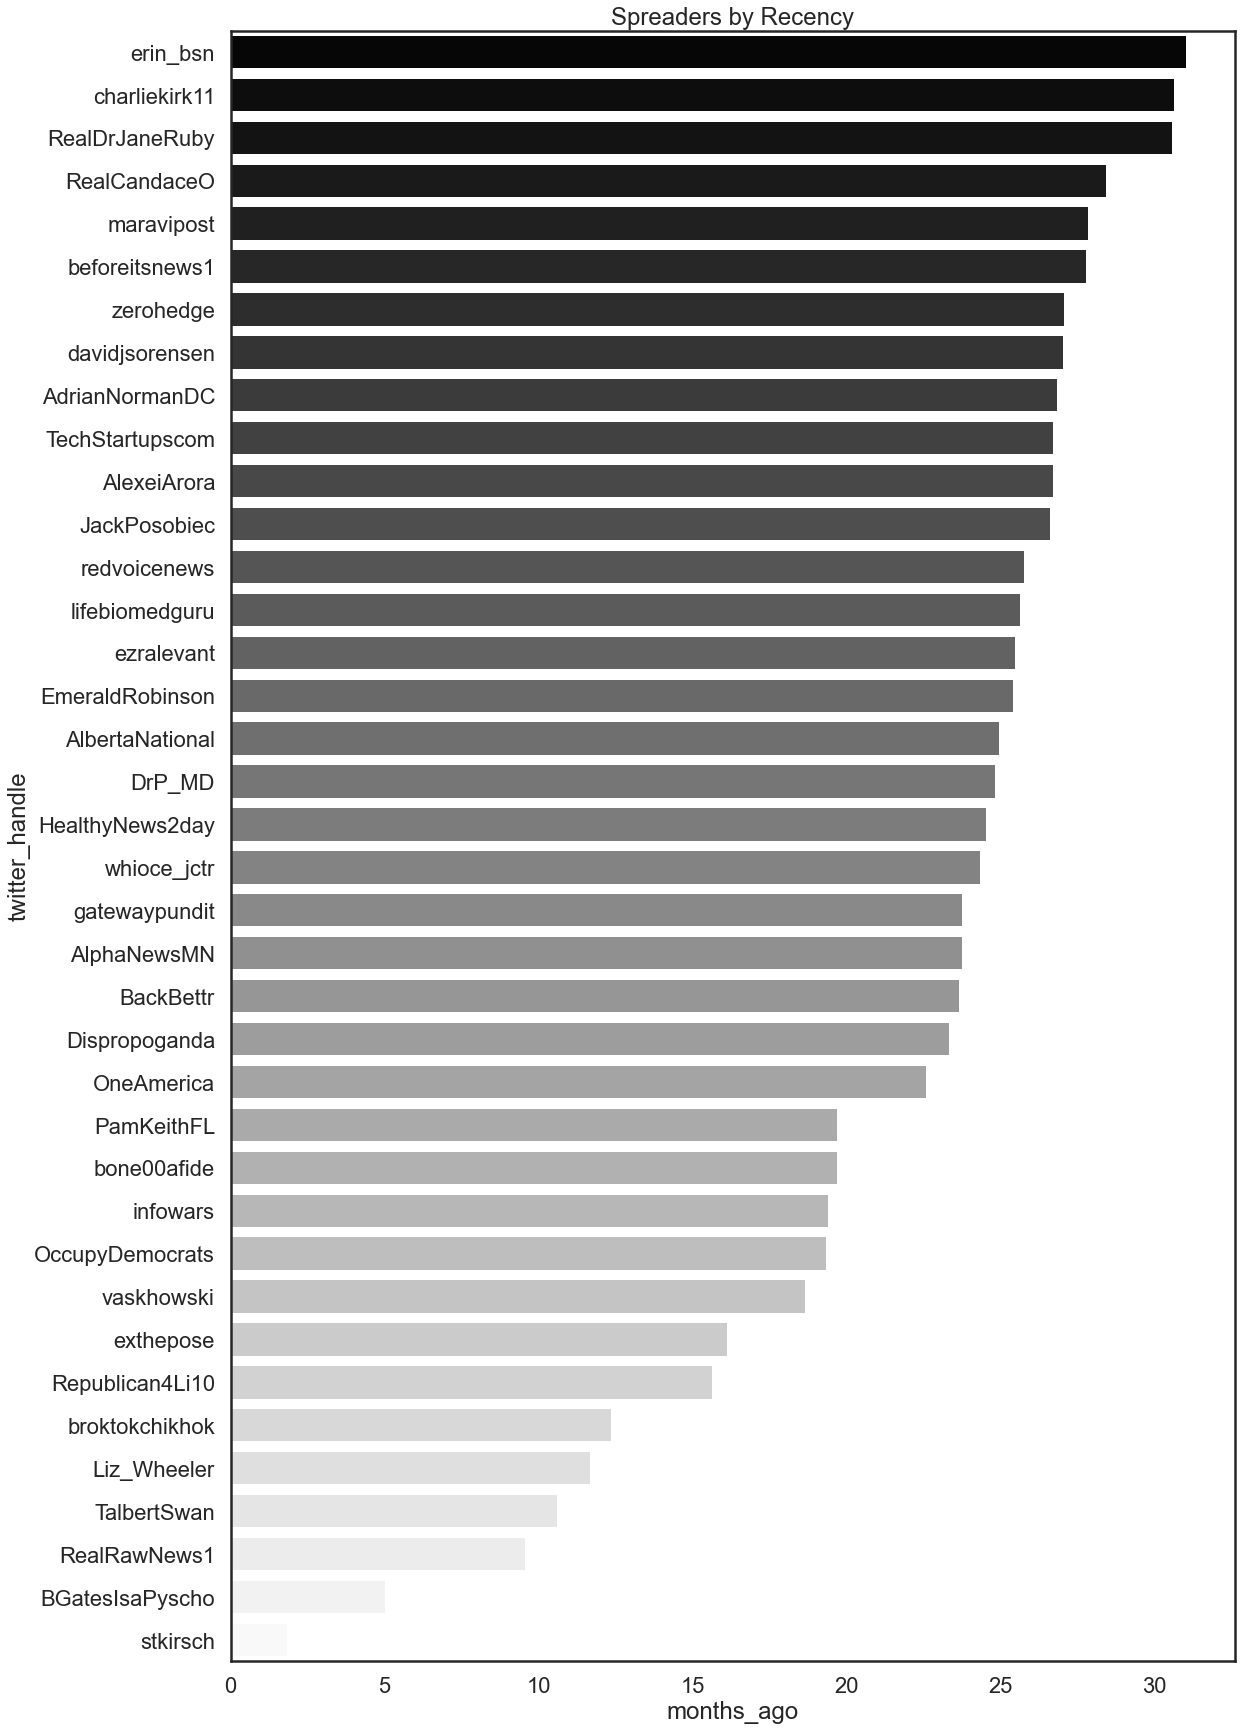

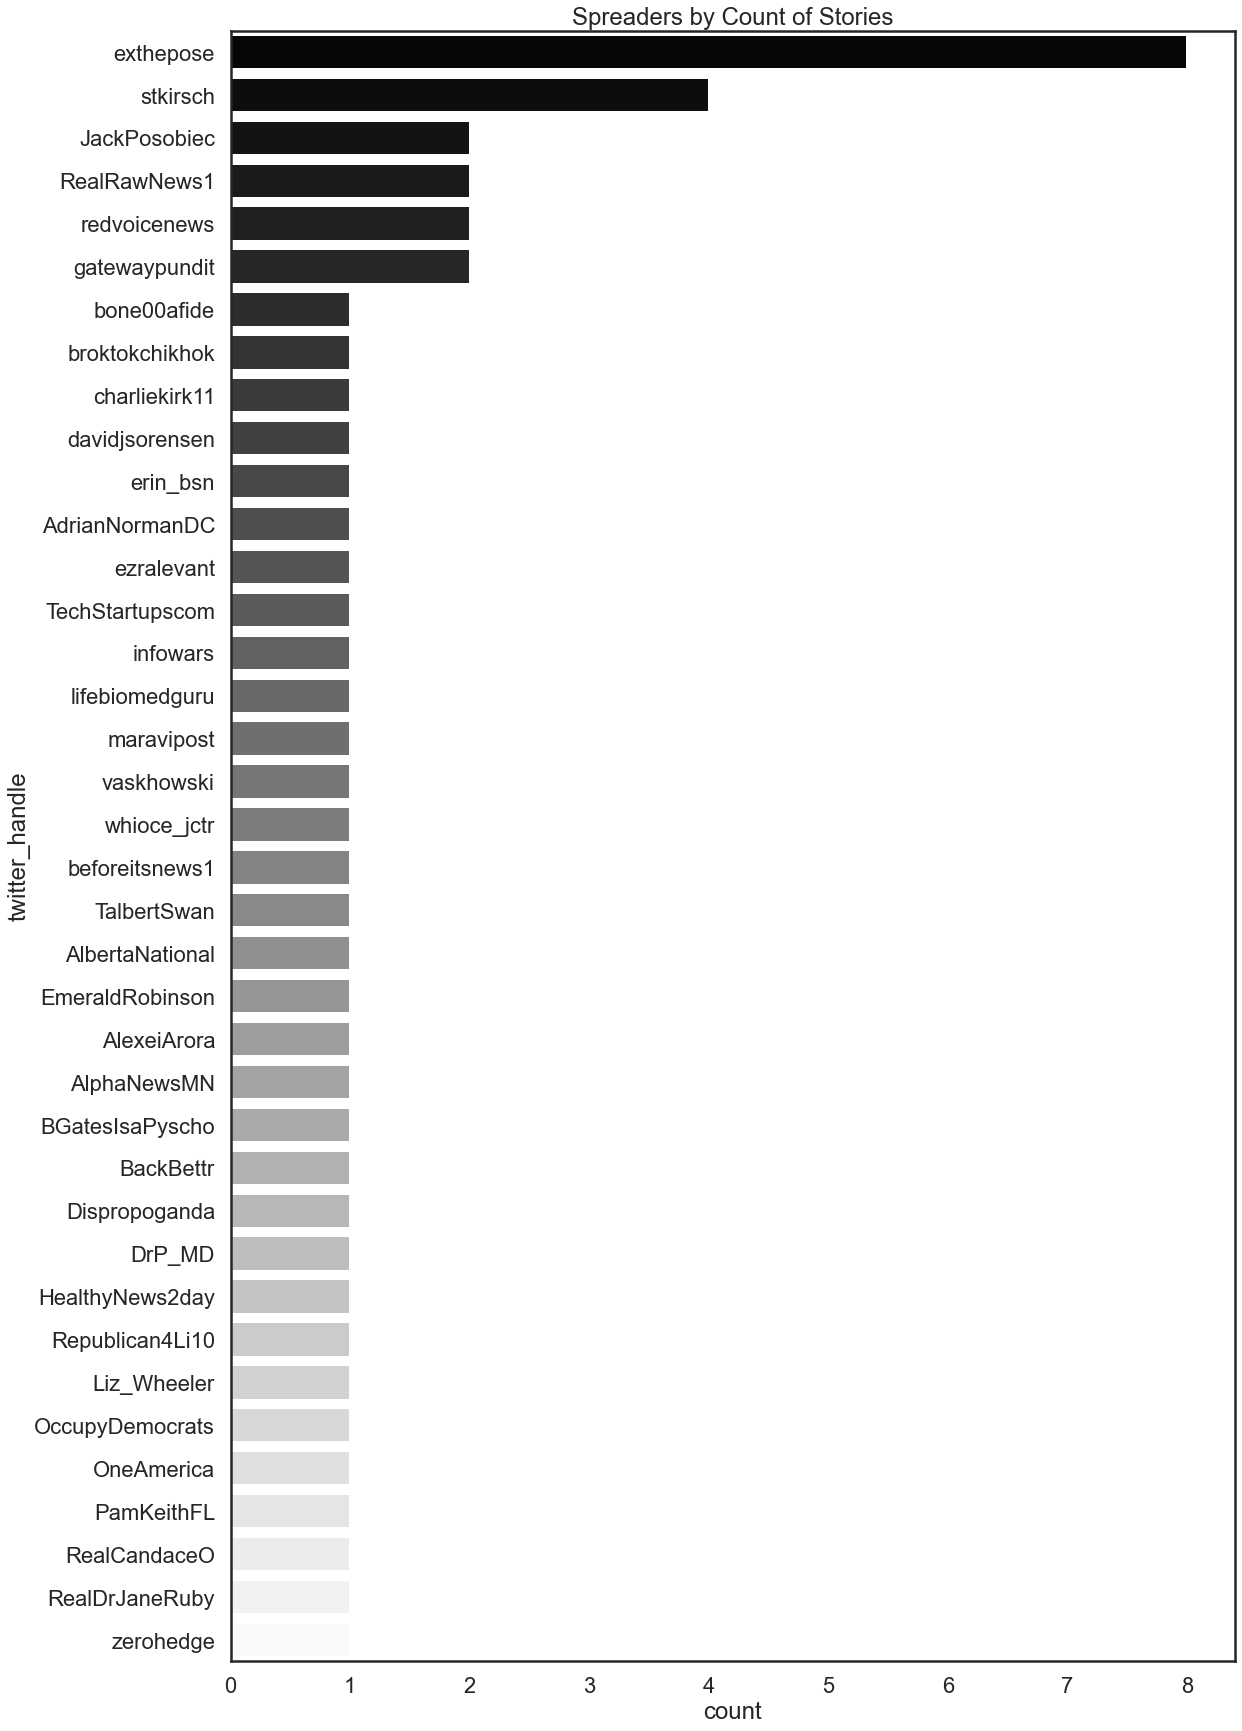

In [9]:
sns.set(context="poster", style='white')

def create_bar_plot(df, title, y_label, x_label):
    sorted_df = df.sort_values(by=x_label, ascending=False)
    plt.figure(figsize=(18, 30))
    plt.title(title)
    sns.barplot(data=sorted_df, y=y_label, x=x_label, palette='binary_r')
    plt.show()

plot_details = {
    "Spreaders by Index (Neutral Weight)": 'rank_neutral_emph',
    "Spreaders by Index (Count Emphasis)": 'rank_count_emph',
    "Spreaders by Index (Follower Emphasis)": 'rank_follower_emph',
    "Spreaders by Index (Recent Emphasis)": 'rank_recent_emph',
    "Spreaders by Index (Recent + Follow)":'rank_recent_follow',
    "Spreaders by Number of Followers": 'n_followers',
    "Spreaders by Recency": 'months_ago',
    "Spreaders by Count of Stories": 'count'
}

for title, sort_column in plot_details.items():
    create_bar_plot(new_df, title, 'twitter_handle', sort_column)  
    

# Final selection -- top by count

In [10]:
new_df.sort_values(by=['rank_recent_follow'], ascending=False).head(10)

,twitter_handle,n_followers,count,last_story,days_ago,months_ago,log_followers,rank_log_followers,rank_last_story,rank_count,rank_neutral_emph,rank_count_emph,rank_follower_emph,rank_recent_emph,rank_recent_follow
10,JackPosobiec,2394648.0,2,2021-10-14,799,26.633333,14.688747,36.0,12.0,34.5,27.500000,31.350,32.175,18.975,35.25
29,gatewaypundit,669931.0,2,2022-01-07,714,23.800000,13.414930,33.0,21.5,34.5,29.666667,32.325,31.500,25.175,33.75
34,stkirsch,450066.0,4,2023-10-27,56,1.866667,13.017150,30.0,38.0,37.0,35.000000,36.100,32.250,36.650,33.50
15,RealCandaceO,4558915.0,1,2021-08-20,854,28.466667,15.332595,38.0,4.0,16.5,19.500000,17.850,29.675,10.975,27.25
24,charliekirk11,2720331.0,1,2021-06-15,920,30.666667,14.816264,37.0,2.0,16.5,18.500000,17.400,28.675,9.425,26.75
33,redvoicenews,47541.0,2,2021-11-08,774,25.800000,10.769348,18.0,13.0,34.5,21.833333,28.800,19.725,16.975,26.25
37,zerohedge,1770870.0,1,2021-09-30,813,27.100000,14.386982,35.0,7.0,16.5,19.500000,17.850,28.025,12.625,25.75
11,Liz_Wheeler,944794.0,1,2023-01-05,351,11.700000,13.758722,34.0,34.0,16.5,28.166667,21.750,31.375,31.375,25.25
17,RealRawNews1,41247.0,2,2023-03-09,288,9.600000,10.627334,16.0,36.0,34.5,28.833333,31.950,21.775,32.775,25.25
27,exthepose,7760.0,8,2022-08-24,485,16.166667,8.956738,11.0,31.0,38.0,26.666667,32.900,18.050,29.050,24.50


In [11]:
for n in range(3,10):
    t_topn = new_df.sort_values(by=['rank_recent_follow'], ascending=False).head(n)
    print(f"TopN={n}, followers(M) = {np.sum(t_topn['n_followers'])/1000000}")

TopN=3, followers(M) = 3.514645
TopN=4, followers(M) = 8.07356
TopN=5, followers(M) = 10.793891
TopN=6, followers(M) = 10.841432
TopN=7, followers(M) = 12.612302
TopN=8, followers(M) = 13.557096
TopN=9, followers(M) = 13.598343


In [12]:
topn = new_df.sort_values(by=['rank_recent_follow'], ascending=False).head(5)
topn['twitter_handle'].to_csv("handles.txt", index=False, header=False)